# XGBoost Hyperparameter tuning with Feature Engineering

We experiment with feature engineering for time data.

Hyperparameter tuning for this feature set for the Kaggle competition: https://www.kaggle.com/c/bike-sharing-demand
See the main notebook for a full explanation

The notebook is organized into the following sections:
- Feature Engineering
- XGBoost Model hyperparameter tuning for 


Data Notes: (see main notebook for details)
Notation notes: think of variable 'data' as the raw data table

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)


C:\Users\dhamm\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Preparation


In [2]:
data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB



### Cleaning up the date format:
- convert to datetime
- change index
- add date col
- add y,m,d,hr cols
- drop datetime col

In [3]:
data['datetime'] = pd.to_datetime(data.datetime)
data.index = data.datetime
data['date'] = data['datetime'].dt.date

data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data = data.drop(["datetime"], axis = 1)

### Change to categorical variables

In [4]:
cat_vars = ["season","holiday","workingday","weather","hour","year","month","day"]
for var in cat_vars:
    data[var] = data[var].astype("category")


from sklearn.model_selection import train_test_split

reg_cat_vars = ['season','weather','hour','year','month','day']
cat_dummies = pd.get_dummies(dataDropped[reg_cat_vars], drop_first = True)
cat_dummies = cat_dummies.drop(['weather_4'], axis=1) #only 1 data point had category 4 weather

dataReg = pd.concat([dataDropped[['temp','humidity','holiday','workingday']], cat_dummies], axis=1)

X_train, X_test, y_train, y_test = train_test_split(dataReg, dataDropped['count'], test_size=0.2, random_state=0)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Feature Engineering
Since time is cyclic in nature (23.00 is close to 00.00), we encode the hour of the day feature to better reflect this.


In [5]:
data['sinhour'], data['coshour'] = np.sin(2*np.pi*data.hour/24), np.cos(2*np.pi*data.hour/24)

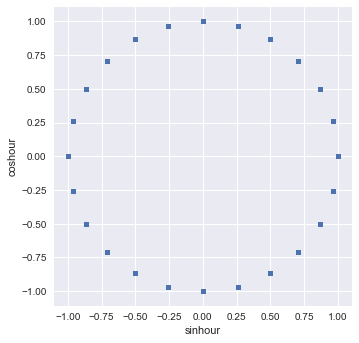

In [6]:
#check encoding
data.plot.scatter('sinhour','coshour').set_aspect('equal');
plt.show()

We perform the same encoding on months

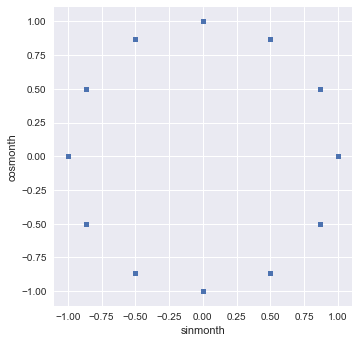

In [7]:
data['sinmonth'], data['cosmonth'] = np.sin(2*np.pi*data.month/12), np.cos(2*np.pi*data.month/12)
#check encoding
data.plot.scatter('sinmonth','cosmonth').set_aspect('equal');
plt.show()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 20 columns):
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
date          10886 non-null object
year          10886 non-null category
month         10886 non-null category
day           10886 non-null category
hour          10886 non-null category
sinhour       10886 non-null float64
coshour       10886 non-null float64
sinmonth      10886 non-null float64
cosmonth      10886 non-null float64
dtypes: category(8), float64(7), int64(4), object(1)
memory usage: 1.2+ MB


# XGBoost Model

Define Error Function

In [9]:
def rmsle(y, y_preds): #error function defined in the competition
    y = np.exp(y)
    y_preds = np.exp(y_preds)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_preds]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Create training and test set with dummy and one-hot-encoding. XGBoost is very "robust to correlated variables" so no need to remove certain vars.


In [32]:
from sklearn.model_selection import train_test_split

cat_vars.remove("day") #won't be using day predictor for XGB since 20th-30th doesn't exist in training data
cat_vars.remove("hour")
cat_vars.remove("month") #we encoded these earlier

one_hot_vars = pd.get_dummies(data[cat_vars], drop_first = True)
one_hot_vars = one_hot_vars.drop(['weather_4'], axis=1) #only 1 data point had category 4 weather
oneHotData = pd.concat([data[['temp','atemp','humidity','windspeed','sinhour','coshour','sinmonth','cosmonth']], 
                       one_hot_vars], axis=1)

oh_X_train, oh_X_test, oh_y_train, oh_y_test = train_test_split(oneHotData, np.log1p(data['count']), 
                                                                test_size=0.2, random_state=0)

ValueError: list.remove(x): x not in list

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 16 columns):
temp            10886 non-null float64
atemp           10886 non-null float64
humidity        10886 non-null int64
windspeed       10886 non-null float64
sinhour         10886 non-null float64
coshour         10886 non-null float64
sinmonth        10886 non-null float64
cosmonth        10886 non-null float64
season_2        10886 non-null uint8
season_3        10886 non-null uint8
season_4        10886 non-null uint8
holiday_1       10886 non-null uint8
workingday_1    10886 non-null uint8
weather_2       10886 non-null uint8
weather_3       10886 non-null uint8
year_2012       10886 non-null uint8
dtypes: float64(7), int64(1), uint8(8)
memory usage: 1.1 MB


In [12]:
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

def trainModel(X_train, X_test, y_train, y_test, model, erounds):
    xtrain = X_train
    ytrain = y_train
    xtest = X_test
    ytest = y_test

    model.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain),(xtest,ytest)], early_stopping_rounds=erounds)
    return model


def gridSearch(search_params, model, X_train, y_train):
    search = GridSearchCV(estimator = model, param_grid = search_params, 
                          scoring = 'neg_mean_squared_log_error', n_jobs=4, iid=False, cv=5)
    search.fit(X_train, y_train)
    print(search.grid_scores_, search.best_params_, search.best_score_)


Find optimal params and fit model for dummy encoding

In [75]:
%%capture
model_init = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=8,
               min_child_weight=6,
               gamma=0.4,
               subsample=0.8,
               colsample_bytree=0.8,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_init, 50)

Find optimal params and fit model for one hot encoding (one hot encoding has the best chance for max performance)

In [14]:
s1params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(2,10,2)
}

gridSearch(s1params, m, oh_X_train, oh_y_train)

([mean: -0.00715, std: 0.00071, params: {'max_depth': 3, 'min_child_weight': 2}, mean: -0.00714, std: 0.00070, params: {'max_depth': 3, 'min_child_weight': 4}, mean: -0.00713, std: 0.00076, params: {'max_depth': 3, 'min_child_weight': 6}, mean: -0.00723, std: 0.00080, params: {'max_depth': 3, 'min_child_weight': 8}, mean: -0.00672, std: 0.00085, params: {'max_depth': 5, 'min_child_weight': 2}, mean: -0.00666, std: 0.00087, params: {'max_depth': 5, 'min_child_weight': 4}, mean: -0.00675, std: 0.00088, params: {'max_depth': 5, 'min_child_weight': 6}, mean: -0.00670, std: 0.00084, params: {'max_depth': 5, 'min_child_weight': 8}, mean: -0.00720, std: 0.00105, params: {'max_depth': 7, 'min_child_weight': 2}, mean: -0.00717, std: 0.00098, params: {'max_depth': 7, 'min_child_weight': 4}, mean: -0.00714, std: 0.00087, params: {'max_depth': 7, 'min_child_weight': 6}, mean: -0.00705, std: 0.00093, params: {'max_depth': 7, 'min_child_weight': 8}, mean: -0.00787, std: 0.00095, params: {'max_depth'

In [15]:
s2params = {
    'max_depth':[4,5,6],
    'min_child_weight':range(2,7)
}
gridSearch(s2params, m, oh_X_train, oh_y_train)


([mean: -0.00682, std: 0.00083, params: {'max_depth': 4, 'min_child_weight': 2}, mean: -0.00689, std: 0.00086, params: {'max_depth': 4, 'min_child_weight': 3}, mean: -0.00686, std: 0.00079, params: {'max_depth': 4, 'min_child_weight': 4}, mean: -0.00687, std: 0.00084, params: {'max_depth': 4, 'min_child_weight': 5}, mean: -0.00680, std: 0.00086, params: {'max_depth': 4, 'min_child_weight': 6}, mean: -0.00672, std: 0.00085, params: {'max_depth': 5, 'min_child_weight': 2}, mean: -0.00669, std: 0.00082, params: {'max_depth': 5, 'min_child_weight': 3}, mean: -0.00666, std: 0.00087, params: {'max_depth': 5, 'min_child_weight': 4}, mean: -0.00669, std: 0.00087, params: {'max_depth': 5, 'min_child_weight': 5}, mean: -0.00675, std: 0.00088, params: {'max_depth': 5, 'min_child_weight': 6}, mean: -0.00694, std: 0.00090, params: {'max_depth': 6, 'min_child_weight': 2}, mean: -0.00689, std: 0.00101, params: {'max_depth': 6, 'min_child_weight': 3}, mean: -0.00688, std: 0.00087, params: {'max_depth'

In [76]:
%%capture
model_2 = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=5,
               min_child_weight=4,
               gamma=0,
               subsample=0.8,
               colsample_bytree=0.8,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m2 = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_2, 50)

In [17]:
s3params = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gridSearch(s3params, m2, oh_X_train, oh_y_train)



([mean: -0.00684, std: 0.00092, params: {'gamma': 0.0}, mean: -0.00684, std: 0.00082, params: {'gamma': 0.1}, mean: -0.00681, std: 0.00082, params: {'gamma': 0.2}, mean: -0.00673, std: 0.00085, params: {'gamma': 0.3}, mean: -0.00666, std: 0.00087, params: {'gamma': 0.4}], {'gamma': 0.4}, -0.006658332040017643)


In [77]:
%%capture
model_3 = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=5,
               min_child_weight=4,
               gamma=0.4,
               subsample=0.8,
               colsample_bytree=0.8,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m3 = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_3, 50)

In [19]:
s4params = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gridSearch(s4params, m3, oh_X_train, oh_y_train)

([mean: -0.00714, std: 0.00084, params: {'subsample': 0.6, 'colsample_bytree': 0.6}, mean: -0.00707, std: 0.00087, params: {'subsample': 0.7, 'colsample_bytree': 0.6}, mean: -0.00689, std: 0.00074, params: {'subsample': 0.8, 'colsample_bytree': 0.6}, mean: -0.00690, std: 0.00083, params: {'subsample': 0.9, 'colsample_bytree': 0.6}, mean: -0.00677, std: 0.00083, params: {'subsample': 0.6, 'colsample_bytree': 0.7}, mean: -0.00698, std: 0.00083, params: {'subsample': 0.7, 'colsample_bytree': 0.7}, mean: -0.00692, std: 0.00089, params: {'subsample': 0.8, 'colsample_bytree': 0.7}, mean: -0.00675, std: 0.00086, params: {'subsample': 0.9, 'colsample_bytree': 0.7}, mean: -0.00693, std: 0.00097, params: {'subsample': 0.6, 'colsample_bytree': 0.8}, mean: -0.00679, std: 0.00078, params: {'subsample': 0.7, 'colsample_bytree': 0.8}, mean: -0.00666, std: 0.00087, params: {'subsample': 0.8, 'colsample_bytree': 0.8}, mean: -0.00671, std: 0.00087, params: {'subsample': 0.9, 'colsample_bytree': 0.8}, me

In [78]:
%%capture
model_4 = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=5,
               min_child_weight=5,
               gamma=0.4,
               subsample=0.8,
               colsample_bytree=0.8,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m4 = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_4, 50)

In [22]:
s5params = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gridSearch(s5params, m4, oh_X_train, oh_y_train)

([mean: -0.00683, std: 0.00086, params: {'subsample': 0.75, 'colsample_bytree': 0.75}, mean: -0.00669, std: 0.00087, params: {'subsample': 0.8, 'colsample_bytree': 0.75}, mean: -0.00670, std: 0.00089, params: {'subsample': 0.85, 'colsample_bytree': 0.75}, mean: -0.00683, std: 0.00086, params: {'subsample': 0.75, 'colsample_bytree': 0.8}, mean: -0.00669, std: 0.00087, params: {'subsample': 0.8, 'colsample_bytree': 0.8}, mean: -0.00670, std: 0.00089, params: {'subsample': 0.85, 'colsample_bytree': 0.8}, mean: -0.00677, std: 0.00088, params: {'subsample': 0.75, 'colsample_bytree': 0.85}, mean: -0.00678, std: 0.00087, params: {'subsample': 0.8, 'colsample_bytree': 0.85}, mean: -0.00674, std: 0.00084, params: {'subsample': 0.85, 'colsample_bytree': 0.85}], {'subsample': 0.8, 'colsample_bytree': 0.75}, -0.006692968190343085)


In [79]:
%%capture
model_5 = XGBRegressor(learning_rate = 0.2,
               n_estimators=300,
               max_depth=5,
               min_child_weight=5,
               gamma=0.4,
               subsample=0.8,
               colsample_bytree=0.75,
               objective= 'reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m5 = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_5, 50)

In [28]:
s6params = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gridSearch(s6params, m5, oh_X_train, oh_y_train)

([mean: -0.00669, std: 0.00087, params: {'reg_alpha': 1e-05}, mean: -0.00666, std: 0.00088, params: {'reg_alpha': 0.01}, mean: -0.00686, std: 0.00086, params: {'reg_alpha': 0.1}, mean: -0.00680, std: 0.00087, params: {'reg_alpha': 1}, mean: -0.01316, std: 0.00153, params: {'reg_alpha': 100}], {'reg_alpha': 0.01}, -0.006664516994973095)


In [29]:
s7params = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gridSearch(s7params, m5, oh_X_train, oh_y_train)

([mean: -0.00669, std: 0.00087, params: {'reg_alpha': 0}, mean: -0.00673, std: 0.00091, params: {'reg_alpha': 0.001}, mean: -0.00677, std: 0.00084, params: {'reg_alpha': 0.005}, mean: -0.00666, std: 0.00088, params: {'reg_alpha': 0.01}, mean: -0.00670, std: 0.00079, params: {'reg_alpha': 0.05}], {'reg_alpha': 0.01}, -0.006664516994973095)


In [80]:
%%capture
#this is the final model we want to train
model_6 = XGBRegressor(learning_rate = 0.01,
               n_estimators=3000,
               max_depth=5,
               min_child_weight=5,
               gamma=0.4,
               subsample=0.8,
               colsample_bytree=0.75,
               reg_alpha = 0.01,
               objective='reg:linear',
               scale_pos_weight=1,
               silent = True,
               seed=1)
m6 = trainModel(oh_X_train, oh_X_test, oh_y_train, oh_y_test, model_6, 50)

# Predicting and writing to file


In [53]:
testdata = pd.read_csv("test.csv")
testdata.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [54]:
testdata['datetime'] = pd.to_datetime(testdata.datetime)
testdata['date'] = testdata['datetime'].dt.date

testdata['year'] = testdata['datetime'].dt.year
testdata['month'] = testdata['datetime'].dt.month
testdata['day'] = testdata['datetime'].dt.day
testdata['hour'] = testdata['datetime'].dt.hour
testdata.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,year,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011-01-20,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011-01-20,2011,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011-01-20,2011,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011-01-20,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011-01-20,2011,1,20,4


### Change to categorical variables

In [56]:
testdata['sinhour'], testdata['coshour'] = np.sin(2*np.pi*testdata.hour/24), np.cos(2*np.pi*testdata.hour/24)
testdata['sinmonth'], testdata['cosmonth'] = np.sin(2*np.pi*testdata.month/12), np.cos(2*np.pi*testdata.month/12)

cat_vars = ["season","holiday","workingday","weather","year"]
for var in cat_vars:
    testdata[var] = testdata[var].astype("category")

one_hot_vars = pd.get_dummies(testdata[cat_vars], drop_first = True)
one_hot_vars = one_hot_vars.drop(['weather_4'], axis=1) #only 1 data point had category 4 weather
testoneHotData = pd.concat([testdata[['temp','atemp','humidity','windspeed','sinhour','coshour','sinmonth','cosmonth']], 
                       one_hot_vars], axis=1)

In [57]:
testoneHotData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 16 columns):
temp            6493 non-null float64
atemp           6493 non-null float64
humidity        6493 non-null int64
windspeed       6493 non-null float64
sinhour         6493 non-null float64
coshour         6493 non-null float64
sinmonth        6493 non-null float64
cosmonth        6493 non-null float64
season_2        6493 non-null uint8
season_3        6493 non-null uint8
season_4        6493 non-null uint8
holiday_1       6493 non-null uint8
workingday_1    6493 non-null uint8
weather_2       6493 non-null uint8
weather_3       6493 non-null uint8
year_2012       6493 non-null uint8
dtypes: float64(7), int64(1), uint8(8)
memory usage: 456.6 KB


### Make Predictions

In [72]:
predictions = m6.predict(testoneHotData)
predictions = np.exp(predictions)
result = pd.concat([testdata.datetime, pd.Series(predictions)], axis=1)
result.tail()

,datetime,0
6488,2012-12-31 19:00:00,271.699249
6489,2012-12-31 20:00:00,196.457016
6490,2012-12-31 21:00:00,157.486847
6491,2012-12-31 22:00:00,128.412415
6492,2012-12-31 23:00:00,80.845810


In [73]:
result.columns = ['datetime','count']
result[:].tail()

,datetime,count
6488,2012-12-31 19:00:00,271.699249
6489,2012-12-31 20:00:00,196.457016
6490,2012-12-31 21:00:00,157.486847
6491,2012-12-31 22:00:00,128.412415
6492,2012-12-31 23:00:00,80.845810


In [74]:
result.to_csv(path_or_buf = 'predictions.csv', index=False)